In [2]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB, BernoulliNB
from sklearn import metrics
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.feature_selection import SelectKBest, mutual_info_classif, f_classif, chi2
import nltk
import pandas as pd
from sklearn import metrics
import numpy as np 
from sklearn.pipeline import Pipeline 
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.tree import DecisionTreeClassifier
from sklearn import preprocessing, linear_model, metrics, datasets, multiclass, svm
from sklearn.model_selection import train_test_split, cross_val_score
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold, cross_val_score
from random import randint
import pickle

In [9]:
# loading data
df = pd.read_csv('./Consumer_Complaints.csv')
df.shape

C:\Users\admin\AppData\Local\Temp\ipykernel_11884\98951488.py:2: DtypeWarning: Columns (5,11) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('./Consumer_Complaints.csv')


(670598, 18)

In [10]:

df['ZIP code']=df['ZIP code'].astype(str)
print(df.dtypes)

Date received                   object
Product                         object
Sub-product                     object
Issue                           object
Sub-issue                       object
Consumer complaint narrative    object
Company public response         object
Company                         object
State                           object
ZIP code                        object
Tags                            object
Consumer consent provided?      object
Submitted via                   object
Date sent to company            object
Company response to consumer    object
Timely response?                object
Consumer disputed?              object
Complaint ID                     int64
dtype: object


In [11]:
df.dtypes

Date received                   object
Product                         object
Sub-product                     object
Issue                           object
Sub-issue                       object
Consumer complaint narrative    object
Company public response         object
Company                         object
State                           object
ZIP code                        object
Tags                            object
Consumer consent provided?      object
Submitted via                   object
Date sent to company            object
Company response to consumer    object
Timely response?                object
Consumer disputed?              object
Complaint ID                     int64
dtype: object

In [12]:
pd.notnull(df['Consumer complaint narrative']).value_counts()


False    555894
True     114704
Name: Consumer complaint narrative, dtype: int64

In [13]:
Data = df[['Product','Consumer complaint narrative']]
Data = Data[pd.notnull(Data['Consumer complaint narrative'])]
Data

,Product,Consumer complaint narrative
57729,Credit card,Received Capital One charge card offer XXXX. A...
57787,Debt collection,I do n't know how they got my cell number. I t...
57838,Credit card,I 'm a longtime member of Charter One Bank/RBS...
57848,Credit reporting,"After looking at my credit report, I saw a col..."
57852,Debt collection,I received a call from a XXXX XXXX from XXXX @...
...,...,...
670582,Mortgage,My mother XXXX in XXXX with a reverse mortgage...
670588,Credit card,Chase rejects customer payments claiming that ...
670590,Credit card,I filed for chapter XXXX protection 5 years ag...
670594,Mortgage,We purchased our home in XX/XX/XXXX at the pea...


In [14]:
Data.shape

(114704, 2)

In [15]:
pd.DataFrame(df.Product.unique()).values


array([['Consumer Loan'],
       ['Bank account or service'],
       ['Mortgage'],
       ['Debt collection'],
       ['Credit card'],
       ['Credit reporting'],
       ['Student loan'],
       ['Money transfers'],
       ['Payday loan'],
       ['Other financial service'],
       ['Prepaid card'],
       ['Virtual currency']], dtype=object)

In [16]:
df2 = Data.sample(10000, random_state=1).copy()


In [17]:
df2.replace({'Product': 
             {'Credit reporting, credit repair services, or other personal consumer reports': 
              'Credit reporting, repair, or other', 
              'Credit reporting': 'Credit reporting, repair, or other',
             'Credit card': 'Credit card or prepaid card',
             'Prepaid card': 'Credit card or prepaid card',
             'Payday loan': 'Payday loan, title loan, or personal loan',
             'Money transfer': 'Money transfer, virtual currency, or money service',
             'Virtual currency': 'Money transfer, virtual currency, or money service'}}, 
            inplace= True)

In [18]:
pd.DataFrame(df2.Product.unique())


,0
0,"Credit reporting, repair, or other"
1,Mortgage
2,Consumer Loan
3,Debt collection
4,Credit card or prepaid card
5,Student loan
6,Bank account or service
7,"Payday loan, title loan, or personal loan"
8,Money transfers
9,Other financial service


In [19]:
df2['category_id'] = df2['Product'].factorize()[0]
category_id_df = df2[['Product', 'category_id']].drop_duplicates()


category_to_id = dict(category_id_df.values)
id_to_category = dict(category_id_df[['category_id', 'Product']].values)

df2.head()

,Product,Consumer complaint narrative,category_id
235971,"Credit reporting, repair, or other",I have been notified by XXXX XXXX XXXX that my...,0
222288,Mortgage,INDY MAC WAS MY LOAN SERVICING COMPANY FROM TH...,1
103986,Consumer Loan,In 2006 my identity was stolen when my vehicle...,2
629167,Debt collection,Harris and Harris from XXXX IL has been callin...,3
500008,Debt collection,"They have called twice already this morning, u...",3


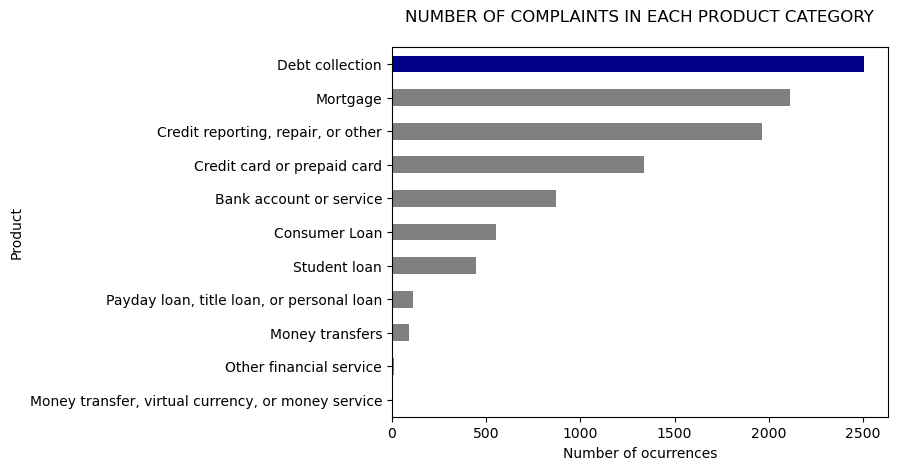

In [20]:
fig = plt.figure()
colors = ['grey','grey','grey','grey','grey','grey','grey','grey','grey',
    'grey','darkblue','darkblue','darkblue']
df2.groupby('Product')['Consumer complaint narrative'].count().sort_values().plot.barh(
    ylim=0, color=colors, title= 'NUMBER OF COMPLAINTS IN EACH PRODUCT CATEGORY\n')
plt.xlabel('Number of ocurrences', fontsize = 10);

In [21]:
tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5,
                        ngram_range=(1, 2), 
                        stop_words='english')

# We transform each complaint into a vector
features = tfidf.fit_transform(df2['Consumer complaint narrative']).toarray()

labels = df2.category_id

print("Each of the %d complaints is represented by %d features (TF-IDF score of unigrams and bigrams)" %(features.shape))

Each of the 10000 complaints is represented by 26574 features (TF-IDF score of unigrams and bigrams)


In [195]:
X = df2['Consumer complaint narrative'] # Collection of documents
y = df2['Product'] # Target or the labels we want to predict (i.e., the 13 different complaints of products)

train_x, valid_x,  train_y, valid_y = train_test_split(X, y, 
                                                    test_size=0.25,
                                                    random_state = 0)

In [196]:
X_tr, X_te, Y_tr, Y_te = train_test_split(X, y, 
                                                    test_size=0.25,
                                                    random_state = 0)

In [206]:
classifiers = ['RandomForest', 
              'DecisionTree']

models = [RandomForestClassifier(n_estimators=200, random_state=0),
          DecisionTreeClassifier(random_state=0)]


def acc_score(df,label):
    Score = pd.DataFrame({"Classifier":classifiers})
    j = 0
    acc = []
    X_train,X_test,Y_train,Y_test,indices_train,indices_test = train_test_split(df, 
                                                               label, 
                                                               df2.index, test_size=0.25, 
                                                               random_state=1)
    for i in models:
        model = i
        model.fit(X_train,Y_train)
        predictions = model.predict(X_test)
        acc.append(accuracy_score(Y_test,predictions))
        j = j+1     
    Score["Accuracy"] = acc
    Score.sort_values(by="Accuracy", ascending=False,inplace = True)
    Score.reset_index(drop=True, inplace=True)
    return Score

def plot(score,x,y,c = "b"):
    gen = [1,2,3,4,5]
    plt.figure(figsize=(6,4))
    ax = sns.pointplot(x=gen, y=score,color = c )
    ax.set(xlabel="Generation", ylabel="Accuracy")
    ax.set(ylim=(x,y))

In [207]:
def initilization_of_population(size,n_feat):
    population = []
    for i in range(size):
        chromosome = np.ones(n_feat,dtype=np.bool)     
        chromosome[:int(0.3*n_feat)]=False             
        np.random.shuffle(chromosome)
        population.append(chromosome)
    return population


def fitness_score(population):
    scores = []
    for chromosome in population:
        logmodel.fit(X_train[:, chromosome], Y_train)
        predictions = logmodel.predict(X_test[:, chromosome])
        scores.append(accuracy_score(Y_test,predictions))
    scores, population = np.array(scores), np.array(population) 
    inds = np.argsort(scores)                                    
    return list(scores[inds][::-1]), list(population[inds,:][::-1]) 


def selection(pop_after_fit,n_parents):
    population_nextgen = []
    for i in range(n_parents):
        population_nextgen.append(pop_after_fit[i])
    return population_nextgen


def crossover(pop_after_sel):
    pop_nextgen = pop_after_sel
    for i in range(0,len(pop_after_sel),2):
        new_par = []
        child_1 , child_2 = pop_nextgen[i] , pop_nextgen[i+1]
        new_par = np.concatenate((child_1[:len(child_1)//2],child_2[len(child_1)//2:]))
        pop_nextgen.append(new_par)
    return pop_nextgen


def mutation(pop_after_cross,mutation_rate,n_feat):   
    mutation_range = int(mutation_rate*n_feat)
    pop_next_gen = []
    for n in range(0,len(pop_after_cross)):
        chromo = pop_after_cross[n]
        rand_posi = [] 
        for i in range(0,mutation_range):
            pos = randint(0,n_feat-1)
            rand_posi.append(pos)
        for j in rand_posi:
            chromo[j] = not chromo[j]  
        pop_next_gen.append(chromo)
    return pop_next_gen

def generations(df,label,size,n_feat,n_parents,mutation_rate,n_gen,X_train,
                                   X_test, Y_train, Y_test):
    best_chromo= []
    best_score= []
    population_nextgen=initilization_of_population(size,n_feat)
    for i in range(n_gen):
        scores, pop_after_fit = fitness_score(population_nextgen)
        print('Best score in generation',i+1,':',scores[:1])  #2
        pop_after_sel = selection(pop_after_fit,n_parents)
        pop_after_cross = crossover(pop_after_sel)
        population_nextgen = mutation(pop_after_cross,mutation_rate,n_feat)
        best_chromo.append(pop_after_fit[0])
        best_score.append(scores[0])
    return best_chromo,best_score

In [202]:
score1 = acc_score(features,labels)
score1

,Classifier,Accuracy
0,RandomForest,0.7908
1,DecisionTree,0.6988


In [170]:
print(features.shape)

(10000, 26548)


In [208]:
logmodel = RandomForestClassifier(n_estimators=200, random_state=0,max_depth=20, criterion='gini')
X_train,X_test, Y_train, Y_test = train_test_split(features, labels, 
                                                    test_size=0.25,
                                                    random_state = 0)
chromo_df_bc,score_bc=generations(features,labels,size=80,n_feat=features.shape[1],n_parents=64,mutation_rate=0.20,n_gen=5,
                         X_train = X_train,X_test = X_test,Y_train = Y_train,Y_test = Y_test)

C:\Users\admin\AppData\Local\Temp\ipykernel_9876\893577769.py:4: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  chromosome = np.ones(n_feat,dtype=np.bool)


Best score in generation 1 : [0.742]


KeyboardInterrupt: 

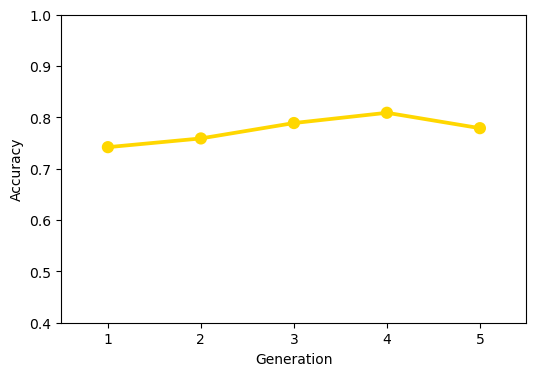

In [210]:
plot(best_score,0.4,1.0,c = "gold")


[[151   1  10   5  16   2   9   0   0   1   1]
 [  2  75   4  11  35   0  10   0   1   0   2]
 [ 15   2 254  19  28   0   5   0   1   0   0]
 [  2   6   7 387  53   0  15   0   0   0   0]
 [  5   6  12  39 560   0  17   0   1   0   7]
 [  9   1   3   1   7   9   1   0   0   0   0]
 [  7   0   4  13  17   0 484   0   0   0   0]
 [  0   0   0   0   1   0   2   0   0   0   1]
 [  0   2   0   0  15   0   4   0   4   0   1]
 [  5   0   5   1   0   0   0   0   0  11   0]
 [  1   2   1   8  13   0   2   0   0   0  88]]


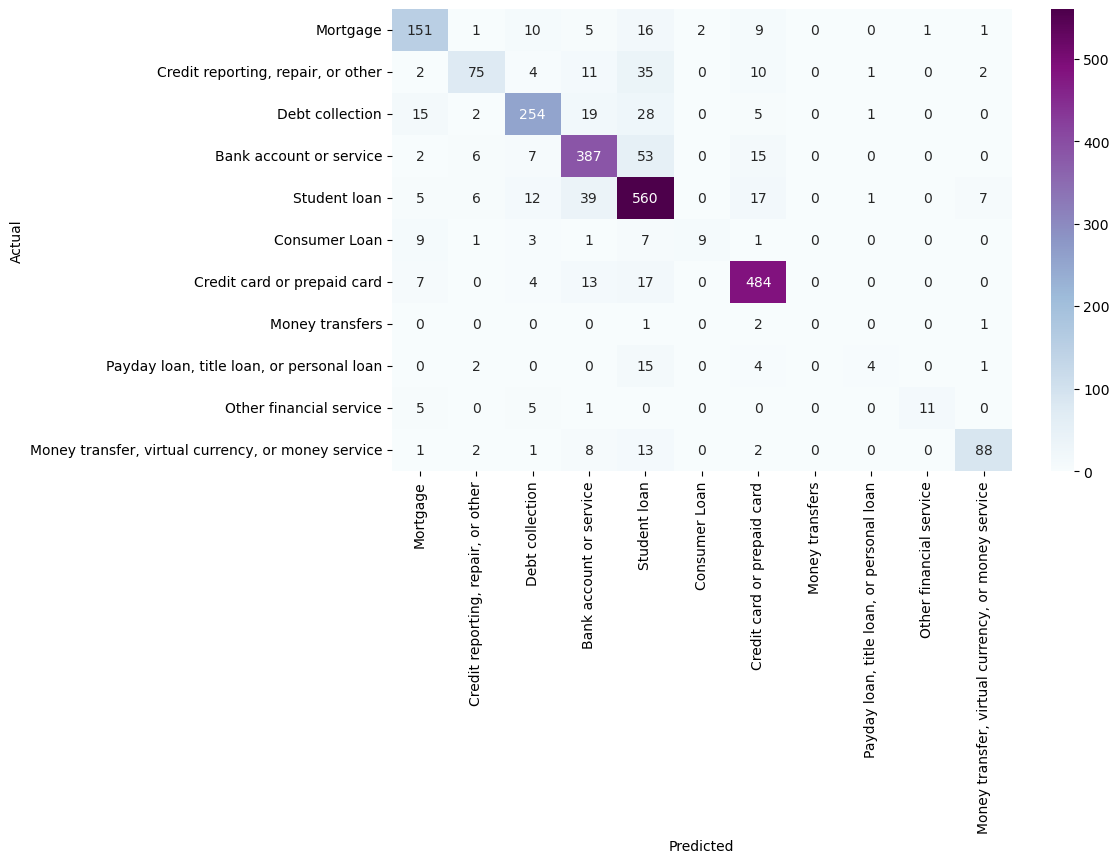

In [89]:
def heat_conf():
    # confusion matrix
    conf_mat = confusion_matrix(valid_y, predicted)
    print(conf_mat)
    # visualizing confusion matrix
    #category_id_df = Data[['product','category_id']].drop_duplicates().sort_values('category_id')
    #category_id_df
    fig, ax = plt.subplots(figsize=(10,6))
    sns.heatmap(conf_mat, annot=True,fmt='d',cmap='BuPu',xticklabels=Data['Product'].unique(),yticklabels=Data['Product'].unique())
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()
    
heat_conf()

In [90]:
print("Classification Report:")
print(metrics.classification_report(valid_y, predicted))

Classification Report:
              precision    recall  f1-score   support

           0       0.77      0.77      0.77       196
           1       0.79      0.54      0.64       140
           2       0.85      0.78      0.81       324
           3       0.80      0.82      0.81       470
           4       0.75      0.87      0.80       647
           5       0.82      0.29      0.43        31
           6       0.88      0.92      0.90       525
           7       0.00      0.00      0.00         4
           8       0.57      0.15      0.24        26
           9       0.92      0.50      0.65        22
          10       0.88      0.77      0.82       115

    accuracy                           0.81      2500
   macro avg       0.73      0.58      0.62      2500
weighted avg       0.81      0.81      0.80      2500



C:\Users\admin\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\admin\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\admin\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
# save the model to disk
filename = 'finalized_model.sav'
pickle.dump(model, open(filename, 'wb'))

In [4]:
filename = 'finalized_model.sav'
loaded_model = pickle.load(open(filename, 'rb'))


In [22]:
texts = ["This account popped up on my credit and it is not mines. I have filled out all the correct docs to show that i am victim of identity thief and will attach the ftc report with this complaint. Please block and remove this from my credit please XXXX XXXX XXXX Account Number: XXXX XXXX / 2019"]
#text_features = tfidf_vect.transform(texts)
predictions = loaded_model.predict(texts)
# print(predictions)
print(texts)
print("   -Predicted as: {}".format(predictions[0]))

['This account popped up on my credit and it is not mines. I have filled out all the correct docs to show that i am victim of identity thief and will attach the ftc report with this complaint. Please block and remove this from my credit please XXXX XXXX XXXX Account Number: XXXX XXXX / 2019']
   -Predicted as: Credit reporting, repair, or other


In [45]:
complaint = [""" i am a student who's soon  going to graduate from the highschool and go to college, i have applied for a loan 3 months ago with no response."""
]
predictions = loaded_model.predict(complaint)
print(complaint)
print("   -Predicted as: {}".format(predictions[0]))

[" i am a student who's soon  going to graduate from the highschool and go to college, i have applied for a loan 3 months ago with no response."]
   -Predicted as: Student loan


In [42]:
new_complaint = ["""Our Mortgage company Roundpoint has been over charging us on Mortgage insurance last year and now they are charging us more this year. My husband has been talking with them since XX/XX/XXXX and each time they say they will fix the problem and it is not fixed. We asked to speak to someone higher then the person on the phone and they state management will not talk to customers. We are very frustrated with this not being resolved. We do not know if this is an honest mistake and the phone people can not figure it out but if sounds very fishy that management will not talk to their customers. I do not know if this is an honest company but after speaking to XXXX people an not getting it resolved I think this company is doing this on purpose."""]
predictions = loaded_model.predict(new_complaint)
print(new_complaint)
print("   -Predicted as: {}".format(predictions[0]))

['Our Mortgage company Roundpoint has been over charging us on Mortgage insurance last year and now they are charging us more this year. My husband has been talking with them since XX/XX/XXXX and each time they say they will fix the problem and it is not fixed. We asked to speak to someone higher then the person on the phone and they state management will not talk to customers. We are very frustrated with this not being resolved. We do not know if this is an honest mistake and the phone people can not figure it out but if sounds very fishy that management will not talk to their customers. I do not know if this is an honest company but after speaking to XXXX people an not getting it resolved I think this company is doing this on purpose.']
   -Predicted as: Mortgage


In [41]:
Data[Data['Consumer complaint narrative'] == new_complaint[0]]


,Product,Consumer complaint narrative
616470,Mortgage,Our Mortgage company Roundpoint has been over ...
